These are the plots for comparing coordinate descent convergence and computational time with and without the SAFE rule.

Helper functions

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import time as time

def soft_thresholding(f, lmbda):
    return np.sign(f) * np.maximum(np.abs(f) - lmbda, 0)

def coord_descent(X, y, lmbda, niter=1000):
    n, p = X.shape
    theta = np.zeros(p)
    for iteration in range(niter):
        for j in range(p):
            rho = X[:, j].T @ (y - X @ theta + X[:, j] * theta[j])
            theta[j] = soft_thresholding(rho / (X[:, j].T @ X[:, j]), lmbda)
    return theta


def safe_rule_lasso(X, y, lmbda, lmbda_max, safe_mask):
    n, p = X.shape
    for i in range(p):
        if not safe_mask[i]:
            inner_product = np.abs(X[:, i].T @ y)
            threshold = np.linalg.norm(X[:, i], ord=2) * np.linalg.norm(y, ord=2) * (lmbda_max - lmbda) / (lmbda_max)

            if inner_product < .15*threshold:
                safe_mask[i] = True
    return safe_mask


def safe_coord_descent(X, y, lmbda, niter=1000):
    n, p = X.shape
    lmbda_max = np.linalg.norm(X.T @ y, ord=np.inf) #infinity norm, from theorem
    theta = np.zeros(p)
    safe_mask = np.zeros(p, dtype=bool)
    for iteration in range(niter):
        safe_mask= safe_rule_lasso(X, y, lmbda, lmbda_max, safe_mask)
        for j in range(p):
            if safe_mask[j]:
                continue  #this coefficient is skipped, because it is zero in the optimal solution.
            rho = X[:, j].T @ (y - X @ theta + X[:, j] * theta[j])
            theta[j] = soft_thresholding(rho / (X[:, j].T @ X[:, j]), lmbda)
    return theta

Experiment 1: Comparing convergence in iterations for coordinate descent vs coordinate descent + safe rule

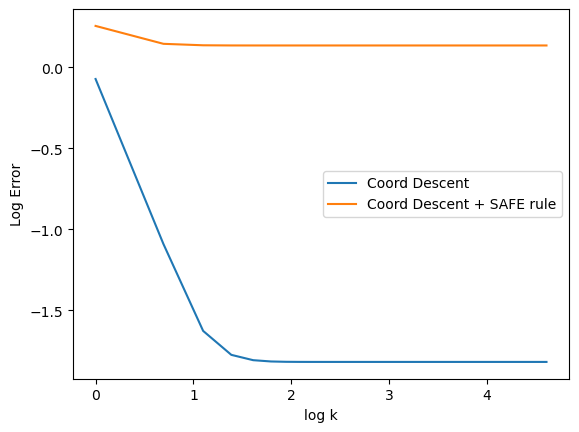

In [7]:
np.random.seed(42)
n, p = 100, 10
lmbda = 0.01
niter = 100
X = np.random.randn(n, p)
theta_hat = np.ones(p)
y = X @ theta_hat + 0.5 * np.random.randn(n)
start_time_cd = time.time()
log_errors_cd = []
log_theta_diffs_cd = []
theta_cd = np.zeros(p)
for k in range(1, niter + 1):
    theta_cd = coord_descent(X, y, lmbda, niter=k)
    log_errors_cd.append(np.log(np.linalg.norm(theta_cd - theta_hat, ord=2)))
time_cd = time.time() - start_time_cd
start_time_safe = time.time()
log_errors_safe = []
theta_safe = np.zeros(p)
for k in range(1, niter + 1):
    theta_safe = safe_coord_descent(X, y, lmbda, niter=k)
    log_errors_safe.append(np.log(np.linalg.norm(theta_safe - theta_hat, ord=2)))
time_safe = time.time() - start_time_safe

plt.plot(np.log(range(1, niter + 1)), log_errors_cd, label='Coord Descent')
plt.plot(np.log(range(1, niter + 1)), log_errors_safe, label='Coord Descent + SAFE rule')
plt.xlabel('log k')
plt.ylabel('Log Error')
plt.legend()
plt.show()

Experiment 2: Comparing computational time

In [9]:
print(f"pure coordinate descent: {time_cd:.4f} seconds")
print(f"with SAFE rule: {time_safe:.4f} seconds")
print(f"Time savings: {time_cd - time_safe:.4f} seconds")


pure coordinate descent: 1.0128 seconds
with SAFE rule: 1.1929 seconds
Time savings: -0.1801 seconds
